In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [14]:
cust=pd.read_csv("/Users/kadiresindhureddy/Downloads/Customers.csv")
trans=pd.read_csv("/Users/kadiresindhureddy/Downloads/Transactions.csv")

In [18]:
#Customer Profile Features
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['TenureDays'] = (datetime.now() - customers['SignupDate']).dt.days

In [20]:
transaction_features = transactions.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    AvgTransactionValue=('TotalValue', 'mean'),
    PurchaseFrequency=('TransactionID', 'count'),
    TotalQuantity=('Quantity', 'sum')
).reset_index()


In [22]:
merged_data = pd.merge(customers, transaction_features, on='CustomerID', how='left').fillna(0)

In [24]:
data_encoded = pd.get_dummies(merged_data, columns=['Region'], drop_first=False)
# Select relevant features
features = data_encoded[['TenureDays', 'TotalSpend', 'AvgTransactionValue', 
                        'PurchaseFrequency', 'TotalQuantity'] + 
                       [col for col in data_encoded.columns if 'Region_' in col]]

In [26]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [28]:
# --- Determine Optimal Clusters ---
db_scores = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_scores.append(davies_bouldin_score(scaled_features, cluster_labels))
    silhouette_scores.append(silhouette_score(scaled_features, cluster_labels))

Text(0, 0.5, 'DB Index')

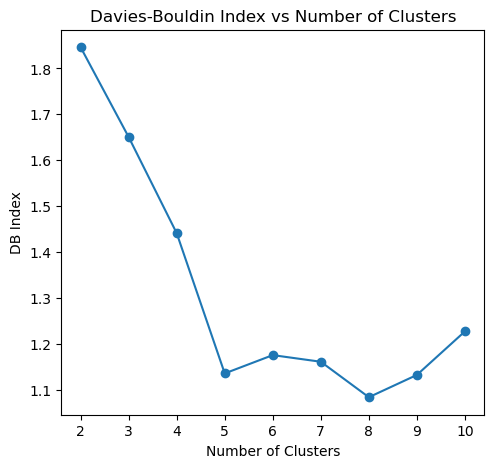

In [30]:
# Plot metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), db_scores, marker='o')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

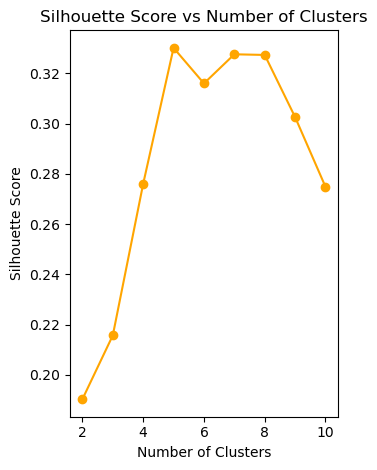

In [32]:
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [34]:
# --- Final Clustering (Using best k from DB Index) ---
best_k = np.argmin(db_scores) + 2  # +2 because range starts at 2
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

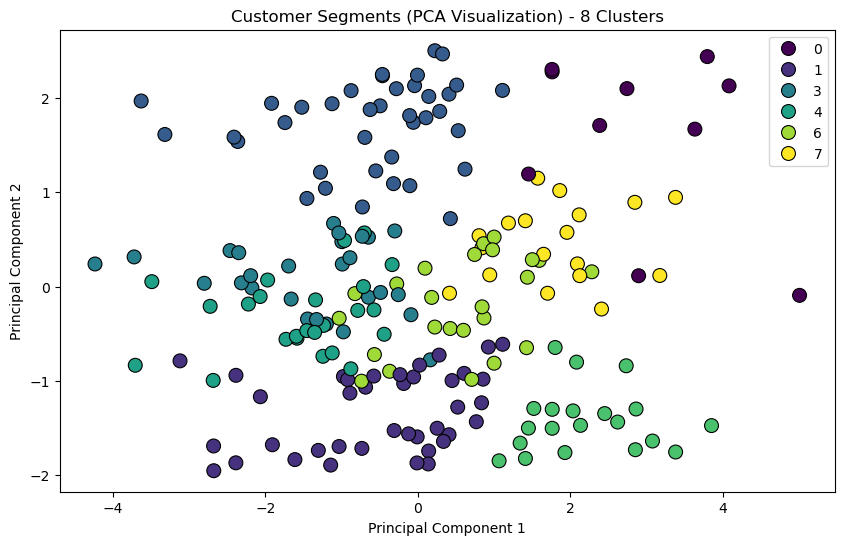

In [36]:
# --- Visualization ---
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=principal_components[:, 0], 
                y=principal_components[:, 1], 
                hue=clusters, 
                palette='viridis',
                s=100,
                edgecolor='k')
plt.title(f'Customer Segments (PCA Visualization) - {best_k} Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [38]:
# --- Cluster Analysis ---
cluster_data = data_encoded.copy()
cluster_data['Cluster'] = clusters

In [40]:
# Analyze cluster characteristics
cluster_profile = cluster_data.groupby('Cluster').agg({
    'TenureDays': 'mean',
    'TotalSpend': 'mean',
    'AvgTransactionValue': 'mean',
    'PurchaseFrequency': 'mean',
    'TotalQuantity': 'mean'
}).reset_index()

In [42]:
print("\nCluster Profile Summary:")
print(cluster_profile.round(2))

# --- Generate Insights ---
print("\nKey Insights:")
print("1. High-Value Customers: Cluster {} shows highest average spending (${}) and transaction frequency".format(
    cluster_profile['TotalSpend'].idxmax(),
    cluster_profile['TotalSpend'].max().round(2)
))
print("2. New/Low-Engagement: Cluster {} has lowest tenure ({} days) and spending".format(
    cluster_profile['TenureDays'].idxmin(),
    cluster_profile['TenureDays'].min().round(2)
))
print("3. Bargain Shoppers: Cluster {} has highest purchase quantity but lowest average transaction value".format(
    cluster_profile['TotalQuantity'].idxmax()
))


Cluster Profile Summary:
   Cluster  TenureDays  TotalSpend  AvgTransactionValue  PurchaseFrequency  \
0        0      550.50     6530.39               726.03               9.10   
1        1      566.64     2654.37               610.45               4.31   
2        2      439.11     2724.53               628.82               4.53   
3        3      557.22     2046.17               666.03               3.07   
4        4      629.46     1857.15               489.03               3.79   
5        5      751.80     5791.61               876.59               6.80   
6        6      521.00     4381.68               890.05               5.17   
7        7      541.50     5379.35               736.29               7.50   

   TotalQuantity  
0          24.10  
1          10.21  
2          10.71  
3           7.67  
4           8.25  
5          19.55  
6          14.25  
7          19.61  

Key Insights:


AttributeError: 'float' object has no attribute 'round'

In [46]:
print("4. Loyal Customers: Cluster {} combines above-average tenure and consistent purchase frequency".format(
    cluster_profile[(cluster_profile['TenureDays'] > cluster_profile['TenureDays'].mean()) &
                   (cluster_profile['PurchaseFrequency'] > cluster_profile['PurchaseFrequency'].mean())].index[0]
))
print("5. Regional Preferences: Significant variation observed in regional distribution")

# --- Save Cluster Labels ---
cluster_data[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)

4. Loyal Customers: Cluster 5 combines above-average tenure and consistent purchase frequency
5. Regional Preferences: Significant variation observed in regional distribution
